# Analyzing the Metadata of Publications in the Open Research Knowledge Graph 
This Jupyter notebook contains different analyses on the metadata of publications stored in the Open Research Knowledge Graph [ORKG](https://www.orkg.org/orkg/).

## Loading Data from the ORKG SPAQRL endpoint

In [303]:
%matplotlib widget
from SPARQLWrapper import SPARQLWrapper, CSV
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

ENDPOINT_URL = "https://www.orkg.org/orkg/triplestore"

PREFIXES =  """
            PREFIX orkgr: <http://orkg.org/orkg/resource/>
            PREFIX orkgc: <http://orkg.org/orkg/class/>
            PREFIX orkgp: <http://orkg.org/orkg/predicate/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            """

query = """
        SELECT ?paper, ?research_field, ?doi, ?title, ?author, ?orcid, ?month, ?year, ?url, ?venue
WHERE {
  ?paper a orkgc:Paper.
  OPTIONAL{?paper rdfs:label ?title.}
  OPTIONAL{?paper orkgp:P26 ?doi.}
  OPTIONAL{?paper orkgp:P30 ?field.
           ?field rdfs:label ?research_field.}
  OPTIONAL{?paper orkgp:P27 ?author_resrc.
           BIND(IF(isLiteral(?author_resrc), ?author_resrc, "") AS ?name1)
           OPTIONAL{?author_resrc rdfs:label ?author_label;
                            orkgp:HAS_ORCID ?orcid.}
           BIND(IF(BOUND(?author_label),?author_label, "") AS ?name2)
           BIND(IF(?name1 = "", ?name2, ?name1) AS ?author)
          }
  
  OPTIONAL{?paper orkgp:P28 ?month_resrc.
           BIND(IF(isLiteral(?month_resrc), ?month_resrc, "") AS ?month1)
           OPTIONAL{?month_resrc rdfs:label ?month_label.}
           BIND(IF(BOUND(?month_label),?month_label, "") AS ?month2)
           BIND(IF(?month1 = "", ?month2, ?month1) AS ?month)
          }
  
  OPTIONAL{?paper orkgp:P29 ?year_resrc.
           BIND(IF(isLiteral(?year_resrc), ?year_resrc, "") AS ?year1)
           OPTIONAL{?year_resrc rdfs:label ?year_label.}
           BIND(IF(BOUND(?year_label),?year_label, "") AS ?year2)
           BIND(IF(?year1 = "", ?year2, ?year1) AS ?year)
          }
  
  OPTIONAL{?paper orkgp:url ?url.}
  OPTIONAL{?paper orkgp:HAS_VENUE ?venue_resrc.
           ?venue_resrc rdfs:label ?venue.}
} ORDER BY ?paper
        """

user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])

sparql = SPARQLWrapper(ENDPOINT_URL, agent=user_agent)
sparql.setQuery(PREFIXES+query)
sparql.setReturnFormat(CSV)

try:
        results = sparql.queryAndConvert()
except Exception as e:
        print(e)

now = datetime.now()
with open('query_result_' + now.strftime('%Y-%m-%d') + '.csv', 'wb') as file:
        file.write(results)

## Initial Data Validation and Check
1. Reading the data and checking the shape and column names.

In [304]:
df = pd.read_csv('query_result_' + now.strftime('%Y-%m-%d') + '.csv', encoding='utf-8', encoding_errors='ignore')

print('Shape of the dataframe: '+ str(df.shape))
print('Column names: ' + str(df.columns))

Shape of the dataframe: (41364, 10)
Column names: Index(['paper', 'research_field', 'doi', 'title', 'author', 'orcid', 'month',
       'year', 'url', 'venue'],
      dtype='object')


2. Checking for NaN values in each column for the entire dataframe.

In [20]:
pd.set_option("max_rows", None)
for column in df:
    print(df[column].isna().value_counts(dropna=False).to_frame())

       paper
False  41364
       research_field
False           41176
True              188
         doi
False  34910
True    6454
       title
False  41354
True      10
       author
False   40974
True      390
       orcid
True   38415
False   2949
       month
False  31442
True    9922
        year
False  39601
True    1763
         url
True   33192
False   8172
       venue
False  25966
True   15398


3. Derterming the number of NaN entries of the column **paper** and the number of unique papers.

In [306]:
#print(df.drop_duplicates(subset='paper')['paper'].value_counts(dropna=False).sum())
print('Number of NaN entries: ' + str(df['paper'].isna().sum()))
print('Number of unique papers: '+ str(df['paper'].nunique()))

Number of NaN entries: 0
Number of unique papers: 9880


4. Checking the number of unique papers per **research field** and the number of unique papers without a research field.

In [13]:
df_unique_papers = df.drop_duplicates(subset='paper')
print('Number of unique papers without a research field: ' + str(df_unique_papers['research_field'].isna().sum()))
df_unique_papers['research_field'].value_counts().to_frame().head(15)

Number of unique papers without a research field: 108


,research_field
Science,3216
Bioinformatics,1188
Ecology and Evolutionary Biology,968
Information Science,324
Artificial Intelligence,304
Toxicology,295
Computer Sciences,238
Urban Studies and Planning,203
Medicinal Chemistry and Pharmaceutics,187
Natural Language Processing,160


5. Checking the number of incorrect entries for the column **doi** and the number of unique papers without a DOI.

In [21]:
incorrect_DOIs = df_unique_papers[~df_unique_papers['doi'].str.startswith('10', na=False)]
print('Number of incorrect DOIs :' + str(incorrect_DOIs['doi'].value_counts().sum()))
print(incorrect_DOIs['doi'].value_counts().to_frame().head(15))
print('Number of unique papers without a DOI: ' + str(df_unique_papers['doi'].isna().sum()))

Number of incorrect DOIs :47
                                             doi
https://doi.org/10.1016/j.eswa.2019.05.052     1
 10.34865/mb0228fstd5_2ad                      1
https://doi.org/10.1016/j.procs.2016.09.123    1
doi.org/10.1016/j.artint.2012.03.006           1
doi.org/10.1016/j.jbi.2013.09.008              1
 10.34865/mb7934d5_2ad                         1
 10.34865/mb11207d5_1                          1
 10.34865/mb10766kskd5_1                       1
 10.34865/mb7943verd5_1                        1
 10.34865/mb10001d5_1                          1
 10.34865/mb311549d5_1                         1
 10.34865/mb6772d5_2ad                         1
https://doi.org/10.14778/2536336.2536343       1
 10.34865/mb744025stad5_2ad                    1
 10.34865/mb8759ismd5_2ad                      1
Number of unique papers without a DOI: 2215


6. Checking the number of unique papers with a specific **title** and the number of unique papers without a title.

In [29]:
#duplicated_title = df.drop_duplicates(subset=['paper'])
print('Number of unique papers without a title: ' + str(df_unique_papers['title'].isna().sum()))
df_unique_papers['title'].value_counts().loc[lambda x : x >= 2].to_frame().head(15)

Number of unique papers without a title: 8


,title
Linking sea level rise and socioeconomic indicators under the Shared Socioeconomic Pathways,14
Governing nonprofit platform ecosystems – an information platform for refugees,14
Creating the European Literary Text Collection (ELTeC): Challenges and Perspectives,9
Solution-processed high-performance p-channel copper tin sulfide thin-film transistors,5
BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding,4
Two New Phytoecdysteroids From Sphenocentrum jollyanum Pierre Root,4
Model and heuristics for the Assembly Line Worker Integration and Balancing Problem,4
A Graph Based Tool for Modelling Planning Processes in Building Engineering,4
"Present-Day Atmospheric Simulations Using GISS ModelE: Comparison to In Situ, Satellite, and Reanalysis Data",4
ScholOnto: an ontology-based digital library server for research documents and discourse,3


In [310]:
print(md_df['month_number'].value_counts(dropna=False))

NaN             9922
1               6156
3               2461
5               2454
10              2445
7               2434
4               2382
8               2269
12              2265
9               2245
11              2131
6               2112
2               2079
October 2020       8
0                  1
Name: month_number, dtype: int64


In [311]:
print(md_df['year_number'].value_counts(dropna=False))

2020.0    3481
2018.0    3441
2017.0    3023
2016.0    2966
2000.0    2799
2019.0    2714
2015.0    2484
2014.0    2203
2013.0    2150
2012.0    1978
NaN       1763
2011.0    1567
2010.0    1354
2021.0    1229
2008.0    1074
2009.0    1038
2006.0     820
2007.0     768
2005.0     624
2004.0     528
2003.0     493
2002.0     386
2001.0     367
1999.0     218
1997.0     180
1998.0     178
1996.0     175
2022.0     131
1994.0     113
1995.0     105
1993.0     103
1992.0     100
1990.0      97
1991.0      90
1987.0      77
1985.0      73
1989.0      62
1988.0      56
1984.0      46
1986.0      37
1978.0      25
1983.0      24
1980.0      21
1981.0      19
1982.0      18
1973.0      17
1974.0      16
1972.0      15
1979.0      13
1977.0      13
1975.0      12
1964.0       9
1976.0       9
1967.0       7
1954.0       6
1962.0       6
1970.0       6
1960.0       5
0.0          5
1959.0       3
1969.0       3
1963.0       3
1968.0       3
1971.0       3
1920.0       3
1958.0       3
1935.0    

<AxesSubplot:xlabel='count', ylabel='field_label'>

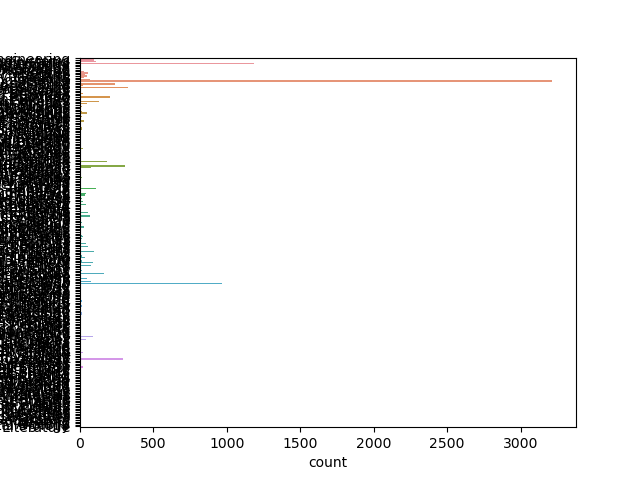

In [312]:
field_df = md_df[['paper','field_label']].drop_duplicates()

pd.set_option("max_rows", None)
field_df[['field_label']].value_counts(dropna=False)

sns.countplot(y='field_label', data=field_df)

In [313]:
df = pd.DataFrame()
nsfg['nbrnaliv'].replace([98,99], np.nan, inplace=True)

df['paper'] = md_df['paper'].astype('str')
df['field'] = md_df['field_label'].astype('category')
df['DOI'] = md_df['DOI'].astype('str')
df['title'] = md_df['title'].astype('str')
df['author'] = md_df['name'].astype('str')
df['orcid'] = md_df['id'].astype('str')
df['month'] = md_df['month_number'].fillna(0.0).astype('int')
df['year'] = md_df['year_number'].fillna(0.0).astype('int')
df['url'] = md_df['paper_url'].astype('str')
df['venue'] = md_df['venue_label'].astype('str')

NameError: name 'nsfg' is not defined